## Подготовка данных

In [1]:
import pandas as pd
import numpy as np

Прочтем и выведем на экран первые пять строчек датасета

In [2]:
data = pd.read_csv('/datasets/autos.csv')
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Размерность

In [3]:
data.shape

(354369, 16)

Некоторые колонки абсолютно бесполезны для предсказания цены, поэтому без сожаления удалим их

In [4]:
data.drop(['DateCrawled', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis=1, inplace=True)

Посмотрим на тип данных каждого столбца

In [5]:
data.dtypes

Price                 int64
VehicleType          object
RegistrationYear      int64
Gearbox              object
Power                 int64
Model                object
Kilometer             int64
RegistrationMonth     int64
FuelType             object
Brand                object
NotRepaired          object
dtype: object

Каждая колонка соответствует требуемому типу

Посмотрим на пропуски в каждом столбце

In [6]:
data.isna().sum()

Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
dtype: int64

Так как пропуски присутствуют только в категориальных признаках, заполним эти пропуски явным обозначением

In [7]:
fillna_col = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'NotRepaired']
data[fillna_col] = data[fillna_col].fillna('unknown')

Пропуски ликвидированны

Проверим наличие аномалий в столбцах с числовыми признаками (Price, RegistrationYear, Power, Kilometer, RegistrationMonth)

count    354369.000000
mean       4416.656776
std        4514.158514
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: Price, dtype: float64

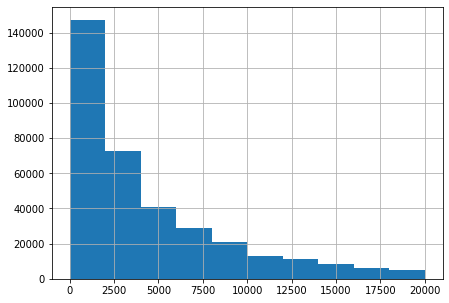

In [8]:
data['Price'].hist(figsize=(7,5))
data['Price'].describe()

count    354369.000000
mean       2004.234448
std          90.227958
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: RegistrationYear, dtype: float64

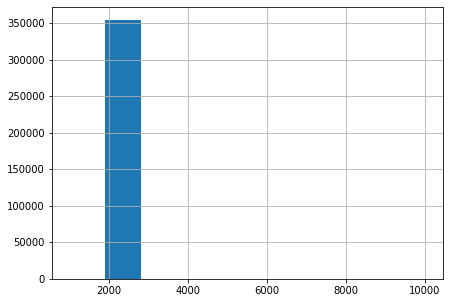

In [9]:
data['RegistrationYear'].hist(figsize=(7,5))
data['RegistrationYear'].describe()

count    354369.000000
mean        110.094337
std         189.850405
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64

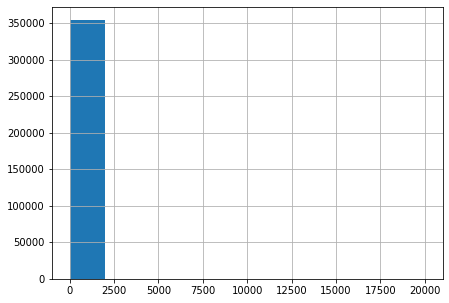

In [10]:
data['Power'].hist(figsize=(7,5))
data['Power'].describe()

count    354369.000000
mean     128211.172535
std       37905.341530
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: Kilometer, dtype: float64

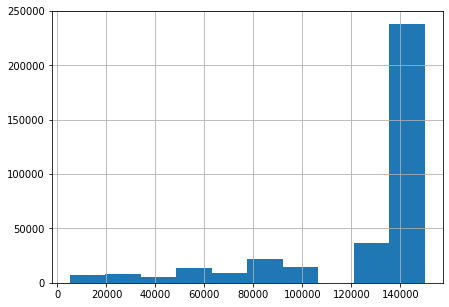

In [11]:
data['Kilometer'].hist(figsize=(7,5))
data['Kilometer'].describe()

count    354369.000000
mean          5.714645
std           3.726421
min           0.000000
25%           3.000000
50%           6.000000
75%           9.000000
max          12.000000
Name: RegistrationMonth, dtype: float64

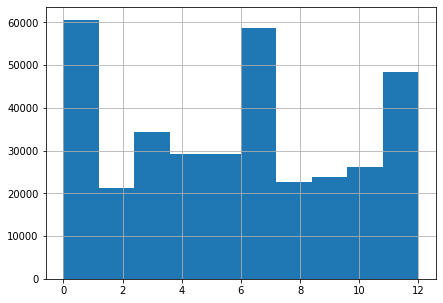

In [12]:
data['RegistrationMonth'].hist(figsize=(7,5))
data['RegistrationMonth'].describe()

Видно, что во всех числовых столбцах, кроме Kilometer, присутствуют аномалии. От них необходимо избавиться, так обучая модели на мусоре, они и будут предсказывать мусор (принцип GIGO)

Для того, чтобы избавиться от аномалий, возьмем за основу стандартный диапазон 1q - 1.5 * iqr; 3q + 1.5 * iqr, где iqr - межквартильный размах. НО, с некоторыми корректировками:
- **Power** - от 1q до 3q + 3iqr. При использовании стандартного диапазона мы уйдем в отрицательные значения с левой стороны. Поэтому эти 1.5iqr "сместим" направо. Тем более, что 365 лошадок вполне реальная цифра (например, для какого-нибудь Ford Mustang);
- **RegistrationMonth** - просто дропнем строки с нулевым месяцем;
- **RegistrationYear** - введем ограничение с 1950 по 2022 год;
- **Price** - введем ограничение только на минимальное значение (1q), так как максимум = 20000 - вполне реальная цена.

In [13]:
data = data.query('69<=Power<=365 and RegistrationMonth!=0 and 1950<=RegistrationYear<=2022 and 1050<=Price').reset_index(drop=True)

## Обучение моделей

### LinearRegression

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder

Выделим категориальные признаки

In [15]:
cat_col = ['VehicleType', 'Gearbox', 'Model', 'FuelType',
           'Brand', 'NotRepaired']

Для того, чтобы обучить линейную регрессию (и модели в следующих пунктах), необходимо преобразовать категоральные признаки в численные. Сделаем это с помощью порядкового кодирования.

In [16]:
encoder = OrdinalEncoder()
encoder.fit(data[cat_col])
data_ordinal = encoder.transform(data[cat_col])
data_ordinal = pd.DataFrame(data_ordinal, columns=data[cat_col].columns)

"Восстановим" столбцы с численными признаками

In [17]:
data_ordinal = data_ordinal.reset_index().merge(data.drop(cat_col, axis=1).reset_index(), on='index')
data_ordinal.drop('index', axis=1, inplace=True)

Разделим данные на признаки и целевой признак

In [18]:
features = data_ordinal.drop('Price', axis=1)
target = data_ordinal['Price']

Разделим признаки и целевой признак на тренировочную и тестовую выборку в соотношении 75:25

In [19]:
features_train, features_test, target_train, target_test = train_test_split(features,
                                                                            target, test_size=0.25, random_state=42)

Размерности полученных выборок:
- features_train - (157936, 10)
- features_test - (52646, 10)
- target_train - (157936, 1)
- target_test - (52646, 1)

Обучим модель

In [36]:
%%time
model = LinearRegression()
model.fit(features_train, target_train)

CPU times: user 37.8 ms, sys: 23.7 ms, total: 61.5 ms
Wall time: 40.1 ms


LinearRegression()

Сделаем предсказание на тестовой выборке

In [37]:
%%time
predict = model.predict(features_test)

CPU times: user 12.8 ms, sys: 5.57 ms, total: 18.3 ms
Wall time: 5.24 ms


RMSE

In [38]:
mean_squared_error(target_test, predict, squared=False)

3058.7558256299635

### RandomForestRegressor

In [39]:
from sklearn.ensemble import RandomForestRegressor

Подберем лучшие значения гиперпараметров модели и обучим ее

In [40]:
%%time
model = RandomForestRegressor()
parameters = {'n_estimators': range(10,51,10)}
grid = GridSearchCV(model, parameters, cv=5)
grid.fit(features_train, target_train)
grid.best_params_

CPU times: user 4min 34s, sys: 2.21 s, total: 4min 36s
Wall time: 4min 36s


{'n_estimators': 50}

Сделаем предсказание на тестовой выборке

In [41]:
%%time
predict = grid.predict(features_test)

CPU times: user 1.13 s, sys: 12 µs, total: 1.13 s
Wall time: 1.12 s


RMSE

In [42]:
mean_squared_error(target_test, predict, squared=False)

1731.2387134412538

### LightGBM

In [21]:
import lightgbm as lgb
from lightgbm import LGBMRegressor

Подберем лучшие значения гиперпараметров модели и обучим ее

In [81]:
%%time
model = LGBMRegressor()
params = {'n_estimators': [40, 50],
          'num_leaves': [21, 31, 41],
          'learning_rate': np.logspace(-3, 0, 10)}
grid_gbm = GridSearchCV(model, params, cv=5)
grid_gbm.fit(features_train, target_train)
grid_gbm.best_params_

CPU times: user 8min 52s, sys: 6.84 s, total: 8min 59s
Wall time: 9min 5s


{'learning_rate': 0.46415888336127775, 'n_estimators': 50, 'num_leaves': 41}

Сделаем предсказание на тестовой выборке

In [82]:
%%time
predict = grid_gbm.predict(features_test)

CPU times: user 192 ms, sys: 16 ms, total: 208 ms
Wall time: 150 ms


RMSE

In [83]:
mean_squared_error(target_test, predict, squared=False)

1779.456130109848

### CatBoost

In [84]:
from catboost import CatBoostRegressor

Так как catboost работает с категориальными признаками напрямую, будем передавать модели признаки, не подверженные кодированию

In [25]:
X = data.drop('Price', axis=1)
y = data['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

Размерности полученных выборок:
- X_train - (157936, 10)
- X_test - (52646, 10)
- y_train - (157936, 1)
- y_test - (52646, 1)

Подберем лучшие значения гиперпараметров модели и обучим ее

In [87]:
%%time
model = CatBoostRegressor(loss_function='RMSE', cat_features=cat_col)
parametrs = {'iterations': [40, 60, 80],
             'learning_rate': np.logspace(-3, 0, 10)}
grid_cbr = GridSearchCV(model, parametrs, cv=5)
grid_cbr.fit(X_train, y_train, verbose=False)
grid_cbr.best_params_

CPU times: user 7min 20s, sys: 3.42 s, total: 7min 23s
Wall time: 9min 9s


{'iterations': 80, 'learning_rate': 0.46415888336127775}

Сделаем предсказание на тестовой выборке

In [88]:
%%time
predict = grid_cbr.predict(X_test)

CPU times: user 67.1 ms, sys: 32 µs, total: 67.2 ms
Wall time: 65 ms


RMSE

In [89]:
mean_squared_error(y_test, predict, squared=False)

1829.2883955101568

## Анализ моделей

Результаты представлены в таблице

In [93]:
pd.DataFrame({'model': ['LinearRegression', ' RandomForestRegressor', 'LightGBM', 'CatBoost'],
              'Training time': ['40.1 ms', '4min 36s', '9min 5s', '9min 9s'],
              'Inference': ['5.24 ms', '1.12 s', '150 ms', '65 ms'],
              'RMSE': [3058.755, 1731.238, 1779.456, 1829.288]})

,model,Training time,Inference,RMSE
0,LinearRegression,40.1 ms,5.24 ms,3058.755
1,RandomForestRegressor,4min 36s,1.12 s,1731.238
2,LightGBM,9min 5s,150 ms,1779.456
3,CatBoost,9min 9s,65 ms,1829.288


**Вывод:** Исходя из полученных данных, можно сделать вывод, что моделью с наилучшим качеством и оптимальным быстродействием оказался случайный лес.

Также, построим график важности факторов и посмотрим, насколько каждый из них важен при моделировании

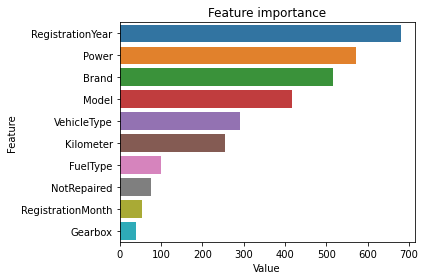

In [34]:
import matplotlib.pyplot as plt    
import seaborn as sns
feature_importance = model.feature_importances_
feature_imp = pd.DataFrame(sorted(zip(feature_importance, features.columns)), columns=['Value','Feature'])
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('Feature importance')
plt.tight_layout()
plt.show();


Из графика видно, что наиболее значимыми факторами при моделировании являются:
- год регистрации автомобиля
- мощность (л. с.)
- марка автомобиля
- модель автомобиля
- тип автомобильного кузова
- пробег (км)